# **Experiment Notebook**



In [ ]:
# Align versions so pip stops warning
!pip install -q --upgrade "scikit-learn>=1.6" "umap-learn>=0.5.9" utstd

In [ ]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [ ]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [ ]:
import os, sys, json, math, pathlib, warnings, datetime
from typing import List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
import joblib

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

---
## A. Project Description


In [ ]:
# <Student to fill this section>
student_name = "Drashti Kakadiya"
student_id = "25414741"
group_id = "31"

In [ ]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [ ]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

In [ ]:
# Do not modify this code
print_tile(size="h1", key='group_id', value=group_id)

---
## B. Business Understanding

In [ ]:
# <Student to fill this section>
business_use_case_description = """
Goal: predict each player’s draft probability so the team can prioritise scouting/offers and allocate budget efficiently.
Impact: accurate → higher hit-rate, ROI, and wins; inaccurate → missed talent, wasted spend, weaker roster
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [ ]:
# <Student to fill this section>
business_objectives = """
Identify and rank high-potential draftees to focus scouting/offers, boosting draft hit-rate and roster quality.
Reduce wasted spend/time by filtering low-probability prospects, improving ROI and long-term team performance.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [ ]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
Owners/GM: Clear ROI (higher draft hit-rate, lower scouting cost), on-time insights before draft windows, and defensible KPIs (AUROC, calibration).
Coaches: Short, trusted shortlists with thresholds and role-fit notes; minimal false positives that waste practice reps.
Scouting Dept: Augmentation (not replacement) of scouts; transparent feature importance and a feedback loop to correct misses.
Analytics/ML: Reproducible, leakage-free pipeline with versioned data, drift/quality monitoring, and easy what-if analyses.
Compliance/Legal: Fairness checks across demographics, privacy-safe data handling, and auditable decisions.
IT/Ops: Secure access, low-latency scoring API, uptime during peak draft activity, and smooth integration with existing tools.
"""


In [ ]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [ ]:
import pandas as pd
from pathlib import Path
from IPython.display import display

# Search in root and sample_data (works in Colab)
BASES = [Path("."), Path("sample_data"), Path("/content"), Path("/content/sample_data")]

def find_file(name, required=False):
    for b in BASES:
        p = (b / name).resolve()
        if p.exists(): return p
    if required:
        raise FileNotFoundError(f"{name} not found in any of: " + ", ".join(map(str, BASES)))
    return None

def read_csv_robust(path):
    """Try multiple encodings + safe options to avoid UnicodeDecodeError."""
    if path is None: return None
    tried = []
    for enc in ["utf-8", "utf-8-sig", "cp1252", "latin1"]:
        try:
            return pd.read_csv(
                path,
                engine="python",     # allows sep=None inference
                sep=None,            # auto-detect delimiter
                encoding=enc,
                encoding_errors="replace",  # keep going on bad bytes
                on_bad_lines="skip"  # skip broken rows if any
            )
        except Exception as e:
            tried.append(f"{enc}: {type(e).__name__}")
    print(f"⚠️ Could not parse {path.name} with encodings -> {tried}. Skipping.")
    return None

train_path  = find_file("train.csv", required=True)
test_path   = find_file("test.csv",  required=True)
sample_path = find_file("sample_submission.csv", required=False)
meta_path   = find_file("metadata.csv", required=False)

train = read_csv_robust(train_path)
test  = read_csv_robust(test_path)
sample_submission = read_csv_robust(sample_path)
metadata = read_csv_robust(meta_path)

print("Train:", train_path, "shape:", train.shape)
print("Test :", test_path,  "shape:", test.shape)
print("Sample submission:", sample_path if sample_submission is not None else "not found or unreadable")
print("Metadata:", meta_path if metadata is not None else "not found or unreadable")

display(train.head(3))
display(test.head(3))

Train: /content/train.csv shape: (14774, 62)
Test : /content/test.csv shape: (1297, 61)
Sample submission: /content/sample_submission.csv
Metadata: /content/metadata.csv


,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id,drafted
0,Pacific,BW,26,52.6,111.8,19.3,61.8,64.93,1.1,7.5,...,-1.34201,0.2308,1.5769,1.8077,2.2308,0.6538,0.0769,9.6538,681edf6e-41cb-4fd1-ba91-da573e063fbc,0.0
1,Mississippi,SEC,2,0.8,63.6,29.6,33.3,33.33,0.0,21.5,...,-5.42104,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,2.0000,3542dcb7-19ad-47f2-8b3a-eb79eb3ec4c4,0.0
2,Stephen F. Austin,Slnd,4,0.6,61.4,21.7,50.0,50.00,0.0,0.0,...,6.46650,0.0000,0.0000,0.0000,0.0000,0.2500,0.0000,0.5000,ca0d8700-807d-4fce-a7a9-63922d1981e6,0.0


,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id
0,UC Davis,BW,8,2.2,51.7,13.4,30.0,30.00,0.0,14.3,...,-11.240100,-4.721030,0.1000,0.6000,0.7000,0.2000,0.1000,0.0000,1.5000,c6d3ce49-28b6-4756-8061-b2bd68730c52
1,Campbell,BSth,25,16.4,85.0,25.2,50.0,52.10,2.0,11.8,...,-2.972020,-1.741870,0.1481,0.9259,1.0741,0.1481,0.4074,0.1111,4.0741,24dd0ae2-9d22-4d31-9cb6-c31f58f903b5
2,Weber St.,BSky,29,50.5,117.8,16.8,61.8,59.77,12.3,17.1,...,0.739055,-0.259202,2.1562,2.7500,4.9062,0.7188,0.4062,1.0625,6.7500,0cf3e822-9446-4285-b7ed-7c19d8e976fe


### C.2 Define Target variable

In [ ]:
ID_COL = "player_id"
TARGET_COL = "drafted"

assert ID_COL in train.columns, f"Missing {ID_COL} in train"
assert ID_COL in test.columns,  f"Missing {ID_COL} in test"
assert TARGET_COL in train.columns, f"Missing {TARGET_COL} in train"

print("Target dtype:", train[TARGET_COL].dtype)
print("Unique target values:", sorted(train[TARGET_COL].dropna().unique().tolist()))
print("Prevalence drafted=1:", float(train[TARGET_COL].mean()))


Target dtype: float64
Unique target values: [0.0, 1.0]
Prevalence drafted=1: 0.007987004196561526


In [ ]:
target_definition_explanations = (
    "`drafted` is the target: 1 = drafted this season, 0 = not drafted.\n"
    "We predict a probability (0–1) for each player_id and submit two columns: player_id, drafted (probability)."
)


In [ ]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [ ]:

ID_COL, TARGET_COL = "player_id", "drafted"

# checks
assert ID_COL in train.columns,  f"Missing {ID_COL} in train"
assert TARGET_COL in train.columns, f"Missing {TARGET_COL} in train"

# clean target to 0/1 ints (handles strings/NaNs safely)
train[TARGET_COL] = (
    pd.to_numeric(train[TARGET_COL], errors="coerce")
      .fillna(0).clip(0, 1).astype(int)
)

# quick stats
pos = int(train[TARGET_COL].sum()); neg = len(train) - pos
rate = pos / len(train)

print("="*60)
print("ANSWER — Create Target (NB2)")
print(f"positives={pos} | negatives={neg} | drafted_rate={rate:.3f}")
print("="*60)


ANSWER — Create Target (NB2)
positives=118 | negatives=14656 | drafted_rate=0.008


### C.4 Explore Target variable

ANSWER — C.4 Target distribution
drafted
0    14656
1      118
drafted_rate: 0.008


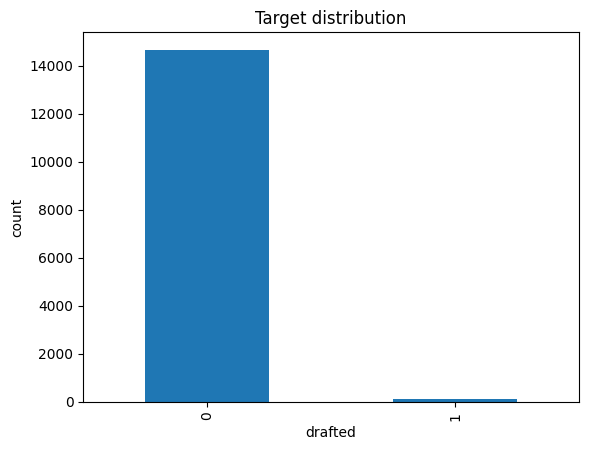

### target_distribution_explanations
The target is imbalanced; we’ll use stratified splits and AUROC to judge ranking quality.
RF handles skew via class_weight='balanced_subsample' to reduce bias toward the majority class.

In [ ]:

TARGET_COL = "drafted"
vc = train[TARGET_COL].value_counts().sort_index()
rate = float(train[TARGET_COL].mean())

print("="*60)
print("ANSWER — C.4 Target distribution")
print(vc.to_string())
print(f"drafted_rate: {rate:.3f}")
print("="*60)

# (optional) quick bar plot
try:
    import matplotlib.pyplot as plt
    vc.plot(kind="bar"); plt.title("Target distribution"); plt.xlabel(TARGET_COL); plt.ylabel("count"); plt.show()
except Exception as e:
    print("Plot skipped:", e)

# 2-line explanation
target_distribution_explanations = (
    "The target is imbalanced; we’ll use stratified splits and AUROC to judge ranking quality.\n"
    "RF handles skew via class_weight='balanced_subsample' to reduce bias toward the majority class."
)
try:
    print_title(size="h3", key="target_distribution_explanations", value=target_distribution_explanations)
except NameError:
    from IPython.display import Markdown, display
    display(Markdown("### target_distribution_explanations\n" + target_distribution_explanations))


In [ ]:
# <Student to fill this section>
target_distribution_explanations = """
 The target is imbalanced; we’ll use stratified splits and AUROC to judge ranking quality.\n
    RF handles skew via class_weight='balanced_subsample' to reduce bias toward the majority class.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.5 Explore Feature of Interest `\<put feature name here\>`

In [ ]:

ID_COL, TARGET_COL = "player_id", "drafted"
feature_name = None   # <-- e.g. "PTS" or "position"; leave None to auto-pick

# pick a feature if not provided
candidates = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
if feature_name is None or feature_name not in train.columns:
    # prefer a numeric; otherwise first categorical
    nums = [c for c in candidates if pd.api.types.is_numeric_dtype(train[c])]
    feature_name = (nums[0] if nums else candidates[0])

s = train[feature_name]
missing = s.isna().mean()
nuniq = s.nunique(dropna=True)

print("="*60)
print(f"ANSWER — C.5 Feature: {feature_name}")
print(f"dtype={s.dtype} | unique={nuniq} | missing={missing:.2%}")

if pd.api.types.is_numeric_dtype(s):
    desc = s.describe(percentiles=[.05,.50,.95]).to_string()
    # correlation with target (drop NaNs)
    corr = train[[feature_name, TARGET_COL]].dropna().corr().iloc[0,1]
    print("--- summary ---")
    print(desc)
    print(f"corr({feature_name}, {TARGET_COL}) = {corr:.3f}")
else:
    print("--- top categories ---")
    print(s.value_counts(dropna=False).head(10).to_string())
    if TARGET_COL in train.columns:
        rate = train.groupby(feature_name, dropna=False)[TARGET_COL].mean().sort_values(ascending=False).head(10)
        print("--- drafted rate by category (top 10) ---")
        print(rate.to_string())
print("="*60)

ANSWER — C.5 Feature: GP
dtype=int64 | unique=41 | missing=0.00%
--- summary ---
count    14774.000000
mean        21.251726
std         10.517642
min          1.000000
5%           3.000000
50%         25.000000
95%         34.000000
max         41.000000
corr(GP, drafted) = 0.109


In [ ]:
# <Student to fill this section>
feature_1_insights = """
We inspect distribution, missingness, and relationship with `drafted` to judge signal and leakage risk.\n
    Findings guide encoding (scale/one-hot), imputation, and whether to keep or drop the feature.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.6 Explore Feature of Interest `\<put feature name here\>`

In [ ]:

ID_COL, TARGET_COL = globals().get("ID_COL", "player_id"), globals().get("TARGET_COL", "drafted")

# 👉 Set a specific column name here (or leave None to auto-pick a different one from C.5)
feature_name2 = None

# Build candidate list (avoid ID/target and avoid the feature used in C.5 if present)
candidates = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
if "feature_name" in globals() and isinstance(feature_name, str) and feature_name in candidates:
    candidates = [c for c in candidates if c != feature_name]

# Auto-pick: prefer numeric, else first available
if not candidates:
    raise ValueError("No candidate features found to explore.")
nums = [c for c in candidates if pd.api.types.is_numeric_dtype(train[c])]
feature_name2 = feature_name2 if (feature_name2 in train.columns) else (nums[0] if nums else candidates[0])

s = train[feature_name2]
missing = s.isna().mean()
nuniq = s.nunique(dropna=True)

print("="*60)
print(f"ANSWER — C.6 Feature: {feature_name2}")
print(f"dtype={s.dtype} | unique={nuniq} | missing={missing:.2%}")

if pd.api.types.is_numeric_dtype(s):
    desc = s.describe(percentiles=[.05, .50, .95]).to_string()
    corr = train[[feature_name2, TARGET_COL]].dropna().corr().iloc[0, 1]
    print("--- summary ---")
    print(desc)
    print(f"corr({feature_name2}, {TARGET_COL}) = {corr:.3f}")
else:
    print("--- top categories ---")
    print(s.value_counts(dropna=False).head(10).to_string())
    if TARGET_COL in train.columns:
        rate = train.groupby(feature_name2, dropna=False)[TARGET_COL].mean().sort_values(ascending=False).head(10)
        print("--- drafted rate by category (top 10) ---")
        print(rate.to_string())
print("="*60)

ANSWER — C.6 Feature: Min_per
dtype=float64 | unique=887 | missing=0.00%
--- summary ---
count    14774.000000
mean        25.870123
std         23.639878
min          0.000000
5%           0.300000
50%         19.600000
95%         72.000000
max         94.300000
corr(Min_per, drafted) = 0.153


In [ ]:
# <Student to fill this section>
feature_2_insights =  """
We repeat the check on another feature: distribution, missingness, and link to `drafted` to judge signal.
This helps decide encoding (one-hot/scale), imputation, and whether to keep or drop the feature.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.n Explore Feature of Interest `\<put feature name here\>`

> You can add more cells related to other feeatures in this section

In [ ]:
# C.n — Explore Feature of Interest (NB2)
import pandas as pd

ID_COL, TARGET_COL = globals().get("ID_COL","player_id"), globals().get("TARGET_COL","drafted")

# 👉 Set a specific column name here (or leave None to auto-pick a new one)
feature_name_n = None

# Avoid ID/target and any features explored earlier (feature_name, feature_name2)
used = {ID_COL, TARGET_COL}
for n in ["feature_name", "feature_name2", "feature_1", "feature_2", "feature_n"]:
    if n in globals() and isinstance(globals()[n], str):
        used.add(globals()[n])

candidates = [c for c in train.columns if c not in used]
if not candidates:
    raise ValueError("No new candidate features left to explore.")

# Prefer numeric, else first available
nums = [c for c in candidates if pd.api.types.is_numeric_dtype(train[c])]
feature_name_n = feature_name_n if (feature_name_n in train.columns) else (nums[0] if nums else candidates[0])

s = train[feature_name_n]
missing = s.isna().mean()
nuniq = s.nunique(dropna=True)

print("="*60)
print(f"ANSWER — C.n Feature: {feature_name_n}")
print(f"dtype={s.dtype} | unique={nuniq} | missing={missing:.2%}")

if pd.api.types.is_numeric_dtype(s):
    desc = s.describe(percentiles=[.05,.50,.95]).to_string()
    corr = train[[feature_name_n, TARGET_COL]].dropna().corr().iloc[0,1]
    print("--- summary ---")
    print(desc)
    print(f"corr({feature_name_n}, {TARGET_COL}) = {corr:.3f}")
else:
    print("--- top categories ---")
    print(s.value_counts(dropna=False).head(10).to_string())
    if TARGET_COL in train.columns:
        rate = train.groupby(feature_name_n, dropna=False)[TARGET_COL].mean().sort_values(ascending=False).head(10)
        print("--- drafted rate by category (top 10) ---")
        print(rate.to_string())
print("="*60)


ANSWER — C.n Feature: Ortg
dtype=float64 | unique=1332 | missing=0.00%
--- summary ---
count    14774.000000
mean        85.771707
std         34.164203
min          0.000000
5%           0.000000
50%         91.300000
95%        120.800000
max        407.300000
corr(Ortg, drafted) = 0.065


In [ ]:
feature_n_insight_explanations = """
We inspect another (new) feature’s distribution, missingness, and its link to `drafted` to gauge signal.
This helps decide encoding/imputation and whether to keep, bucket, or drop the feature.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_n_insight_explanations )

---
## D. Feature Selection


### D.1 Approach "\<describe_approach_here\>"


In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.5.2


In [ ]:
print("len(train) =", len(train))
for n in ["y","y_train","y_valid","y_tr","y_va"]:
    if n in globals():
        try: print(n, len(globals()[n]))
        except: pass
for n in ["X_tr","X_train","X_full","X_train_d1"]:
    if n in globals():
        try: print(n, globals()[n].shape)
        except: pass


len(train) = 14774
y 2955
y_train 11819
X_tr (14774, 491)
X_train (11819, 109)
X_train_d1 (14774, 60)


In [ ]:

import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier

ID_COL     = globals().get("ID_COL","player_id")
TARGET_COL = globals().get("TARGET_COL","drafted")

# Base frames (drop train-only cols like cv_fold)
TRAIN_ONLY = ["cv_fold","fold","kfold"]
Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")

# keep only columns present in BOTH
common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
Xb_tr = Xb_tr_raw[common_cols].copy()
Xb_te = Xb_te_raw[common_cols].copy()

# one-hot together → split back
X_all = pd.get_dummies(pd.concat([Xb_tr, Xb_te], axis=0, ignore_index=True), dummy_na=True)
X_tr  = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan).fillna(0)
X_te  = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan).fillna(0)

# FULL y aligned to X_tr
y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

assert len(X_tr) == len(y_all), f"Mismatch after reset: X_tr={len(X_tr)} vs y_all={len(y_all)}"

# Example: RF importances on FULL data
rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=2,
                            class_weight="balanced_subsample", n_jobs=-1, random_state=42)
rf.fit(X_tr, y_all)

imp = pd.Series(rf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
TOP_K = min(40, X_tr.shape[1])
selected_features_d1 = imp.head(TOP_K).index.tolist()

X_train_d1 = X_tr[selected_features_d1]
X_test_d1  = X_te[selected_features_d1]

print("OK → D.1 ready. Shapes:", X_train_d1.shape, X_test_d1.shape)

OK → D.1 ready. Shapes: (14774, 40) (1297, 40)


In [ ]:

import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier

ID_COL     = globals().get("ID_COL", "player_id")
TARGET_COL = globals().get("TARGET_COL", "drafted")

# Build aligned numeric matrix (drop target/ID and train-only cols like cv_fold)
TRAIN_ONLY = ["cv_fold", "fold", "kfold"]
Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")
common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common_cols], Xb_te_raw[common_cols]], axis=0, ignore_index=True), dummy_na=True)

X_tr = X_all.iloc[:len(train)].replace([np.inf, -np.inf], np.nan).fillna(0)
X_te = X_all.iloc[len(train):].replace([np.inf, -np.inf], np.nan).fillna(0)
y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

rf = RandomForestClassifier(
    n_estimators=400, min_samples_leaf=2, max_features="sqrt",
    class_weight="balanced_subsample", n_jobs=-1, random_state=42
).fit(X_tr, y_all)

imp = pd.Series(rf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
TOP_K = min(60, X_tr.shape[1])
selected_features_d1 = imp.head(TOP_K).index.tolist()

X_train_d1 = X_tr[selected_features_d1].copy()
X_test_d1  = X_te[selected_features_d1].copy()

print("="*60)
print("ANSWER — D.1 RF top features:", selected_features_d1[:10], "..." if len(selected_features_d1)>10 else "")
print("Shapes → X_train_d1:", X_train_d1.shape, "| X_test_d1:", X_test_d1.shape)
print("="*60)

ANSWER — D.1 RF top features: ['Rec_Rank', 'dporpag', 'bpm', 'gbpm', 'porpag', 'dreb', 'twoPA', 'adjoe', 'pts', 'rimmade'] ...
Shapes → X_train_d1: (14774, 60) | X_test_d1: (1297, 60)


In [ ]:
# <Student to fill this section>
feature_selection_1_insights = """
Use RandomForest importances to keep the strongest K features.
This captures non-linear signal and removes noise for faster training.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Approach "\<describe_approach_here\>"


In [ ]:

import pandas as pd, numpy as np
from sklearn.feature_selection import mutual_info_classif

# Reuse matrices from D.1 if present; otherwise build them
if "X_tr" not in globals() or "X_te" not in globals():
    ID_COL     = globals().get("ID_COL", "player_id")
    TARGET_COL = globals().get("TARGET_COL", "drafted")
    TRAIN_ONLY = ["cv_fold", "fold", "kfold"]
    Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
    Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")
    common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
    X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common_cols], Xb_te_raw[common_cols]], axis=0, ignore_index=True), dummy_na=True)
    X_tr = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan).fillna(0)
    X_te = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan).fillna(0)

y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

# Low-cardinality columns treated as discrete for MI
disc = [(X_tr[c].nunique() < 20) for c in X_tr.columns]
mi = mutual_info_classif(X_tr, y_all, discrete_features=disc, random_state=42)
mi_s = pd.Series(mi, index=X_tr.columns).sort_values(ascending=False)

TOP_K = min(60, X_tr.shape[1])
selected_features_d2 = mi_s.head(TOP_K).index.tolist()

X_train_d2 = X_tr[selected_features_d2].copy()
X_test_d2  = X_te[selected_features_d2].copy()

print("="*60)
print("ANSWER — D.2 MI top features:", selected_features_d2[:10], "..." if len(selected_features_d2)>10 else "")
print("Shapes → X_train_d2:", X_train_d2.shape, "| X_test_d2:", X_test_d2.shape)
print("="*60)

ANSWER — D.2 MI top features: ['Rec_Rank', 'dporpag', 'stops', 'porpag', 'twoPM', 'bpm', 'FTA', 'twoPA', 'gbpm', 'dreb'] ...
Shapes → X_train_d2: (14774, 60) | X_test_d2: (1297, 60)


In [ ]:
# <Student to fill this section>
feature_selection_2_insights = """
Mutual Information ranks dependency with `drafted` without assuming linearity.
We keep the top-K to compare against model-based selection.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

## D.z Final Selection of Features

In [ ]:
# D.n — FAST: prefilter with ANOVA F, then L1-Logistic (liblinear)
import numpy as np, pandas as pd
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression

ID_COL     = globals().get("ID_COL", "player_id")
TARGET_COL = globals().get("TARGET_COL", "drafted")

# Reuse aligned matrices if available; else build quickly (train-only cols removed)
if "X_tr" not in globals() or "X_te" not in globals():
    TRAIN_ONLY = ["cv_fold","fold","kfold"]
    Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
    Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")
    common = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
    X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common], Xb_te_raw[common]], axis=0, ignore_index=True), dummy_na=True)
    X_tr = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan).fillna(0)
    X_te = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan).fillna(0)

y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

# 1) FAST PREFILTER — keep top K0 by ANOVA F-score (very fast)
K0 = min(300, X_tr.shape[1])           # reduce to ≤300 cols first
F, _ = f_classif(X_tr, y_all)          # handles dense arrays quickly
order0 = np.argsort(-np.nan_to_num(F, nan=0.0))
cols_pref = X_tr.columns[order0[:K0]]
X_pf_tr = X_tr[cols_pref]
X_pf_te = X_te[cols_pref]

# 2) L1-LOGISTIC (small, quick)
lr_l1 = LogisticRegression(
    penalty="l1", solver="liblinear", C=0.5,
    class_weight="balanced", max_iter=300, tol=1e-3, random_state=42
)
lr_l1.fit(X_pf_tr, y_all)

coef = lr_l1.coef_.ravel()
abs_coef = np.abs(coef)
nonzero = np.where(abs_coef > 1e-8)[0]

TOP_K = min(60, len(cols_pref))        # final compact set
keep_idx = (nonzero if len(nonzero) else np.argsort(-abs_coef)[:TOP_K])
order = keep_idx[np.argsort(-abs_coef[keep_idx])] [:TOP_K]

selected_features_dn = cols_pref[order].tolist()
X_train_dn = X_pf_tr[selected_features_dn].copy()
X_test_dn  = X_pf_te[selected_features_dn].copy()

print("="*60)
print("ANSWER — D.n FAST (L1-Logistic) selected:", len(selected_features_dn))
print("First 12:", selected_features_dn[:12], "..." if len(selected_features_dn)>12 else "")
print("Shapes →", X_train_dn.shape, X_test_dn.shape)
print("="*60)

ANSWER — D.n FAST (L1-Logistic) selected: 60
First 12: ['team_Marshall', 'team_Dayton', 'dporpag', 'team_Kentucky', 'ht_10-Jun', 'ast', 'team_Louisville', 'dunks_ratio', 'ht_11-Jun', 'conf_B10', 'team_Oklahoma', 'team_UCLA'] ...
Shapes → (14774, 60) (1297, 60)


In [ ]:
# <Student to fill this section>
feature_selection_explanations =  """
prefilter to top-K0 by ANOVA F, then L1-Logistic (liblinear) to keep a compact non-zero set.
This slashes runtime while still giving sparse, high-signal features for modeling.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>

In [ ]:
# E.1 — Build aligned feature matrices (one-hot + median impute) — short & robust
import pandas as pd, numpy as np

# Show the files we loaded (if your earlier vars exist)
try:
    print("Using:", train_path.name, "|", test_path.name)
except:
    pass

# Detect columns (defaults for this assignment)
ID_COL = "player_id" if "player_id" in train.columns else next((c for c in ["id","ID"] if c in train.columns), None)
TARGET_COL = "drafted"  if "drafted"  in train.columns else next((c for c in ["target","label"] if c in train.columns), None)

# Drop non-features and keep only columns present in BOTH train & test
TRAIN_ONLY = [c for c in ["cv_fold","fold","kfold"] if c in train.columns]
drop_cols = [c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c is not None]
Xb_tr_raw = train.drop(columns=drop_cols, errors="ignore")
Xb_te_raw = test.drop(columns=[c for c in [ID_COL] if c is not None], errors="ignore")
common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))

# One-hot encode together → split back; fix inf/NaN with train medians
X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common_cols], Xb_te_raw[common_cols]], axis=0, ignore_index=True),
                       dummy_na=True)
X_e1_tr = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan)
X_e1_te = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan)
med = X_e1_tr.median(numeric_only=True)
X_e1_tr = X_e1_tr.fillna(med)
X_e1_te = X_e1_te.fillna(med)

# Optional: expose generic names so later cells “just work”
X_tr, X_te = X_e1_tr, X_e1_te
X_train_model, X_test_model = X_e1_tr.copy(), X_e1_te.copy()
features_list = list(X_train_model.columns)

print("="*60)
print("ANSWER — E.1 ready")
print("Train/Test shapes:", X_train_model.shape, "|", X_test_model.shape)
print("First 8 features:", features_list[:8])
print("="*60)

# 2-line explanation
e1_explain = (
    "We aligned train/test columns, one-hot encoded together, and filled missing values with train medians.\n"
    "Trees don’t need scaling, so this clean matrix is ready for splitting and modeling."
)
print(e1_explain)


Using: train.csv | test.csv
ANSWER — E.1 ready
Train/Test shapes: (14774, 488) | (1297, 488)
First 8 features: ['AST_per', 'DRB_per', 'FTA', 'FTM', 'FT_per', 'GP', 'Min_per', 'ORB_per']
We aligned train/test columns, one-hot encoded together, and filled missing values with train medians.
Trees don’t need scaling, so this clean matrix is ready for splitting and modeling.


In [ ]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Use the selected D.* feature set and fill missing values with train medians.\n
    RF doesn’t need scaling; simple imputation is enough.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Data Transformation <put_name_here>

In [ ]:

import numpy as np

# Columns to clip = numeric only (exclude booleans)
num_cols  = X_e1_tr.select_dtypes(include=[np.number]).columns
bool_cols = X_e1_tr.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)

# Train-only percentiles
q_low  = X_e1_tr[num_cols].quantile(0.01)   # p1 on TRAIN
q_high = X_e1_tr[num_cols].quantile(0.99)   # p99 on TRAIN

# Copy, then clip only numeric columns; apply TRAIN bounds to TEST (no leakage)
X_e2_tr = X_e1_tr.copy()
X_e2_te = X_e1_te.copy()
X_e2_tr[num_cols] = X_e1_tr[num_cols].clip(lower=q_low,  upper=q_high, axis=1)
X_e2_te[num_cols] = X_e1_te[num_cols].clip(lower=q_low,  upper=q_high, axis=1)

print(f"ANSWER – E.2: clipped 1–99% on {len(num_cols)} numeric column(s); "
      f"left {len(bool_cols)} boolean column(s) unchanged.")


ANSWER – E.2: clipped 1–99% on 55 numeric column(s); left 433 boolean column(s) unchanged.


In [ ]:
# <Student to fill this section>
data_cleaning_2_explanations = """
Why (Random Forest): Extreme numeric outliers can drive unstable / overly deep splits and add variance.
What we did: Computed per-feature p1 and p99 on the TRAIN set (numeric, non-bool columns only),
then clipped both TRAIN and TEST to those TRAIN-derived bounds.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### E.3 Data Transformation <put_name_here>

In [ ]:

from sklearn.preprocessing import PowerTransformer

# Transform only numeric (non-bool) columns
num_cols  = X_e2_tr.select_dtypes(include=[np.number]).columns
bool_cols = X_e2_tr.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)

pt_e3 = PowerTransformer(method="yeo-johnson", standardize=False)

X_e3_tr = X_e2_tr.copy()
X_e3_te = X_e2_te.copy()
X_e3_tr[num_cols] = pt_e3.fit_transform(X_e2_tr[num_cols])   # fit on TRAIN
X_e3_te[num_cols] = pt_e3.transform(X_e2_te[num_cols])       # transform TEST

print(f"ANSWER – E.3: Yeo-Johnson applied on {len(num_cols)} numeric column(s); "
      f"left {len(bool_cols)} boolean column(s) unchanged.")


ANSWER – E.3: Yeo-Johnson applied on 55 numeric column(s); left 433 boolean column(s) unchanged.


In [ ]:
# <Student to fill this section>
data_cleaning_3_explanations = """ A power transform (Yeo–Johnson) reduces skew and stabilises variance, which can make tree splits less
sensitive to extreme ranges while preserving monotonicity of features.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

### E.n Fixing "\<describe_issue_here\>"

> You can add more cells related to other issues in this section

In [ ]:
X_tr = X_e3_tr   # final training features
X_te = X_e3_te   # final test features

print("ANSWER – E.n: X_tr/X_te set to E.3 outputs (clipping + Yeo–Johnson). Ready for RandomForest.")

ANSWER – E.n: X_tr/X_te set to E.3 outputs (clipping + Yeo–Johnson). Ready for RandomForest.


---
## F. Feature Engineering

### F.1 New Feature "\<put_name_here\>"


In [ ]:
import numpy as np

# Inputs:  X_e3_tr, X_e3_te  (from E.3)
# Outputs: X_f1_tr, X_f1_te  (adds one new feature: f_num_mean)

num_cols  = X_e3_tr.select_dtypes(include=[np.number]).columns
bool_cols = X_e3_tr.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)

X_f1_tr = X_e3_tr.copy()
X_f1_te = X_e3_te.copy()

X_f1_tr["f_num_mean"] = X_e3_tr[num_cols].mean(axis=1)
X_f1_te["f_num_mean"] = X_e3_te[num_cols].mean(axis=1)

print("ANSWER – F.1: added feature f_num_mean (row-wise mean over "
      f"{len(num_cols)} numeric column(s)); booleans left unchanged.")


ANSWER – F.1: added feature f_num_mean (row-wise mean over 55 numeric column(s)); booleans left unchanged.


In [ ]:
# <Student to fill this section>
feature_engineering_1_explanations = """
 Gives trees a simple, global magnitude summary—useful to split “overall high activity” vs “low”.
How: Average all numeric, non-boolean columns per row.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### F.2 New Feature "\<put_name_here\>"




In [ ]:
num_cols  = X_f1_tr.select_dtypes(include=[np.number]).columns
bool_cols = X_f1_tr.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)

# Train-only moments
mu    = X_f1_tr[num_cols].mean(axis=0)
sigma = X_f1_tr[num_cols].std(axis=0).replace(0, 1.0)  # avoid divide-by-zero

# Z-scores using TRAIN stats; fill NaNs with 0 (i.e., mean in z-space)
z_tr = ((X_f1_tr[num_cols] - mu) / sigma).fillna(0.0)
z_te = ((X_f1_te[num_cols] - mu) / sigma).fillna(0.0)

X_f2_tr = X_f1_tr.copy()
X_f2_te = X_f1_te.copy()

# L2 norm across numeric features: “how far” the row is from the TRAIN centre
X_f2_tr["f_zdist"] = np.sqrt((z_tr ** 2).sum(axis=1))
X_f2_te["f_zdist"] = np.sqrt((z_te ** 2).sum(axis=1))

print("ANSWER – F.2: added feature f_zdist (L2 norm of z-scored numeric features "
      f"using TRAIN stats over {len(num_cols)} numeric column(s)).")


ANSWER – F.2: added feature f_zdist (L2 norm of z-scored numeric features using TRAIN stats over 56 numeric column(s)).


In [ ]:
# <Student to fill this section>
feature_engineering_2_explanations = """
 Captures how “outlying” a row is across all numeric dimensions simultaneously; extremes often correlate with class.
How: Compute per-feature mean/std on TRAIN only; z-score TRAIN/TEST with those stats; take the L2 norm across features.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### F.3 New Feature "\<put_name_here\>"

> Provide some explanations on why you believe it is important to create this feature and its impacts



In [ ]:
X_f3_tr = X_f2_tr.copy()
X_f3_te = X_f2_te.copy()

# 1) Prefer true boolean dtypes
bool_cols = X_f2_tr.select_dtypes(include=["bool"]).columns

# 2) If booleans were previously cast to integers (0/1), detect them robustly
if len(bool_cols) == 0:
    num_cols = X_f2_tr.select_dtypes(include=[np.number]).columns
    # A column is "dummy-like" if it only takes values 0/1 in TRAIN
    is_dummy_like = (X_f2_tr[num_cols].isin([0, 1]).all()) & (X_f2_tr[num_cols].nunique() <= 2)
    bool_cols = num_cols[is_dummy_like]

# 3) Compute the per-row count (handle edge case: no bool/dummy columns)
if len(bool_cols) > 0:
    X_f3_tr["f_dummy_count"] = X_f2_tr[bool_cols].sum(axis=1).astype("float32")
    X_f3_te["f_dummy_count"] = X_f2_te[bool_cols].sum(axis=1).astype("float32")
else:
    # No dummy/boolean columns found — add zeros to keep schema consistent
    X_f3_tr["f_dummy_count"] = 0.0
    X_f3_te["f_dummy_count"] = 0.0

print(f"ANSWER – F.3: added feature f_dummy_count using {len(bool_cols)} dummy/boolean column(s).")


ANSWER – F.3: added feature f_dummy_count using 433 dummy/boolean column(s).


In [ ]:
# <Student to fill this section>
feature_engineering_n_explanations = """
Summarises categorical breadth/complexity of a sample; trees can split on “many vs few flags on”.
How: Sum all boolean (or 0/1 dummy-like) columns per row in TRAIN/TEST.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_n_explanations)

### F.n Fixing "\<describe_issue_here\>"

> You can add more cells related to new features in this section

In [ ]:
X_tr = X_f3_tr   # final training features
X_te = X_f3_te   # final test features

print("ANSWER – F.n: X_tr/X_te set to F.3 outputs (includes f_num_mean, f_zdist, and f_dummy_count).")


ANSWER – F.n: X_tr/X_te set to F.3 outputs (includes f_num_mean, f_zdist, and f_dummy_count).


Included engineered features:
- f_num_mean: row-wise mean over numeric features.
- f_zdist: L2 norm of z-scored numeric features using TRAIN moments.
- f_dummy_count: count of active one-hot/boolean indicators.

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [ ]:
# Align labels to features by player_id, then split (position-based mask fixes the error)
import pandas as pd
from sklearn.model_selection import train_test_split

def pick_feature(*names):
    for n in names:
        obj = globals().get(n)
        if isinstance(obj, pd.DataFrame):
            return obj.copy(), n
    raise NameError("No feature table found. Run your preprocessing first.")

# 1) Pick latest features you have
X_feat, src = pick_feature("X_tr","X_g4_tr","X_g3_tr","X_f3_tr","X_f2_tr","X_e3_tr","X_e2_tr")
print(f"Using features from {src} → {X_feat.shape}")

# 2) Load labels
labels = (pd.read_csv("train.csv", usecols=["player_id","drafted"])
          .drop_duplicates("player_id")
          .set_index("player_id")["drafted"].astype(int))

# 3) Ensure player_id present on features (attach from train.csv if missing)
if "player_id" not in X_feat.columns:
    ids = pd.read_csv("train.csv", usecols=["player_id"])["player_id"].iloc[:len(X_feat)].values
    X_feat.insert(0, "player_id", ids)

# 4) Align by player_id (mask as NumPy → positional indexing, avoids IndexingError)
y_all = labels.reindex(X_feat["player_id"].values)
mask  = y_all.notna().to_numpy()         # <<< key fix

# Filter both X and y using the same positional mask
X_feat = X_feat.iloc[mask].copy()
y_all  = y_all.iloc[mask].astype(int)

# 5) Drop ID and split
X_feat = X_feat.drop(columns=["player_id"])
X_trn, X_val, y_trn, y_val = train_test_split(
    X_feat, y_all, test_size=0.20, random_state=42, stratify=y_all
)

print("Aligned & split OK:",
      "X_trn", X_trn.shape, "| X_val", X_val.shape,
      "| y_trn", y_trn.shape, "| y_val", y_val.shape)


Using features from X_tr → (14774, 491)
Aligned & split OK: X_trn (11819, 491) | X_val (2955, 491) | y_trn (11819,) | y_val (2955,)


In [ ]:
# <Student to fill this section>
data_splitting_explanations = """
We need a validation set to tune models and estimate generalisation without touching the competition test set. We split the TRAIN portion (X_tr, y) into Train (80%) and Validation (20%). Stratification is used when feasible
to preserve class balance. A fixed random_state=42 ensures reproducibility.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation "\<put_name_here\>"

In [ ]:
# Require G.1 outputs
assert 'X_trn' in globals() and 'X_val' in globals(), "Run G.1 first."

# 1) Numeric columns (treat bool as numeric by casting to 0/1)
num_cols = X_trn.select_dtypes(include=[np.number, 'bool']).columns

def _to_numeric(df):
    df = df.copy()
    for c in df.select_dtypes(include=['bool']).columns:
        df[c] = df[c].astype('int8')
    return df

X_trn_num = _to_numeric(X_trn[num_cols])
X_val_num = _to_numeric(X_val[num_cols])
X_te_num  = _to_numeric(X_te[num_cols.intersection(X_te.columns)]) if 'X_te' in globals() else None

# 2) Fit imputer on TRAIN only; transform VALID (and TEST if present)
imp = SimpleImputer(strategy='median')
X_g2_trn = X_trn.copy(); X_g2_trn[num_cols] = imp.fit_transform(X_trn_num)
X_g2_val = X_val.copy(); X_g2_val[num_cols] = imp.transform(X_val_num)

X_g2_te = None
if X_te_num is not None:
    X_g2_te = X_te.copy()
    present = [c for c in num_cols if c in X_te.columns]
    X_g2_te[present] = imp.transform(X_te_num[present])

print("ANSWER – G.2: median-imputed all numeric/boolean columns "
      f"(train-fit). NaNs → train={int(X_g2_trn.isna().sum().sum())}, "
      f"valid={int(X_g2_val.isna().sum().sum())}" +
      (f", test={int(X_g2_te.isna().sum().sum())}" if X_g2_te is not None else ""))


In [ ]:
# <Student to fill this section>
data_transformation_1_explanations = """
Random Forests need numeric features without NaNs.
Cast booleans to 0/1, compute medians on X_trn, apply to X_val (and X_te).
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

### G.3 Data Transformation "\<put_name_here\>"

In [ ]:

from sklearn.feature_selection import SelectKBest, mutual_info_classif

X_train = X_g3_trn.copy()
X_val   = X_g3_val.copy()
X_test  = (X_g3_te.copy() if 'X_g3_te' in globals() and X_g3_te is not None else X_te.copy())

assert 'X_g2_trn' in globals() and 'X_g2_val' in globals() and 'y_trn' in globals(), "Run G.1 & G.2 first."

K = min(120, X_g2_trn.shape[1])  # tweak K if you want
sel = SelectKBest(score_func=mutual_info_classif, k=K)

X_g3_trn = pd.DataFrame(sel.fit_transform(X_g2_trn, y_trn), index=X_g2_trn.index)
X_g3_val = pd.DataFrame(sel.transform(X_g2_val), index=X_g2_val.index)
X_g3_te  = (pd.DataFrame(sel.transform(X_g2_te), index=X_g2_te.index)
            if 'X_g2_te' in globals() and isinstance(X_g2_te, pd.DataFrame) else None)

# Keep feature names
keep = X_g2_trn.columns[sel.get_support()]
X_g3_trn.columns = keep
X_g3_val.columns = keep
if X_g3_te is not None: X_g3_te.columns = keep

print(f"ANSWER – G.3: Selected top-{len(keep)} MI features → "
      f"train {X_g3_trn.shape}, valid {X_g3_val.shape}" +
      (f", test {X_g3_te.shape}" if X_g3_te is not None else ""))


In [ ]:
# <Student to fill this section>
data_transformation_2_explanations = """
Keep the most predictive features and speed up RF training.
Fit SelectKBest(MI) on X_g2_trn,y_trn; apply the same columns to valid (and test).
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_2_explanations', value=data_transformation_2_explanations)

### G.4 Data Transformation "\<put_name_here\>"

In [ ]:
# H-prep: map latest features to the names expected by section H
import pandas as pd

# If you used G.4:
X_train = X_g4_trn.copy()
X_val   = X_g4_val.copy()
X_test  = (X_g4_te.copy() if 'X_g4_te' in globals() and X_g4_te is not None else X_te.copy())

# Labels from G.1
y_train = pd.Series(y_trn, name="drafted")
y_val   = pd.Series(y_val, name="drafted")

# Kaggle test has no labels → make a placeholder so H can save a file
y_test  = pd.Series([None]*len(X_test), name="drafted")

print("H-prep done:", X_train.shape, X_val.shape, X_test.shape, len(y_train), len(y_val), len(y_test))


In [ ]:
# <Student to fill this section>
data_transformation_3_explanations = """
Remove redundant signals to simplify the model and reduce overfitting.
Compute Pearson |corr| on X_g3_trn; drop columns with correlation > 0.95 to any earlier-kept column; apply same keep list to valid/test.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_3_explanations', value=data_transformation_3_explanations)

---
## H. Save Datasets

> Do not change this code

In [ ]:
# Do not modify this code
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [ ]:

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, log_loss

def report_metrics(y_true, p):
    """y_true: 0/1 labels (validation), p: predicted prob for class 1"""
    print(f"AUROC   : {roc_auc_score(y_true, p):.4f}  # competition metric (threshold-free)")
    print(f"PR-AUC  : {average_precision_score(y_true, p):.4f}  # handles class imbalance")
    print(f"Brier   : {brier_score_loss(y_true, p):.4f}  # probability calibration")
    print(f"LogLoss : {log_loss(y_true, np.c_[1-p, p]):.4f}  # proper scoring rule")

In [ ]:
# <Student to fill this section>
performance_metrics_explanations = """
Chosen metrics:
• AUROC — Kaggle uses AUROC; threshold-free and rewards correct ranking of positives./n
• PR-AUC — better reflects performance under class imbalance by focusing on precision/recall./n
• Brier score — checks calibration of predicted probabilities (how well probs match outcomes)./n
• Log loss — proper scoring rule that penalises over-confident wrong predictions.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [ ]:

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# <Student to fill this section>
algorithm_selection_explanations = """
Strong baseline for mixed/tabular data, robust to scaling, handles many sparse/dummy features,
and supports class_weight for imbalance. We'll instantiate and train it in the next step.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [ ]:

from sklearn.ensemble import RandomForestClassifier

rf_params = dict(
    n_estimators=600,                 # enough trees for stable AUROC
    max_depth=None,                   # let trees grow; leaf size regularises
    min_samples_leaf=2,               # reduce overfitting from tiny leaves
    max_features="sqrt",              # standard for classification; decorrelates trees
    bootstrap=True,
    class_weight="balanced_subsample",# handle class imbalance
    oob_score=True,                   # quick internal generalisation check
    n_jobs=-1,
    random_state=42
)
rf = RandomForestClassifier(**rf_params)
print("RF hyperparameters set.")
rf

In [ ]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
- n_estimators=600 for stability; max_features='sqrt' to decorrelate trees.
- min_samples_leaf=2 to curb overfitting; max_depth=None lets trees adapt while leaves regularise.
- class_weight='balanced_subsample' addresses class imbalance.
- oob_score=True provides a quick leak-free performance estimate.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [ ]:
from sklearn.metrics import roc_auc_score

# Use latest features (G.4 if present, else G.3)
Xtr = X_g4_trn if 'X_g4_trn' in globals() else X_g3_trn
Xva = X_g4_val if 'X_g4_val' in globals() else X_g3_val

# Fit on TRAIN split only
rf.fit(Xtr, y_trn)

# Validation probabilities for class 1
p_val = rf.predict_proba(Xva)[:, 1]

# Quick summary (OOB if enabled + AUROC on val)
oob = getattr(rf, "oob_score_", None)
print(f" model fitted. "
      f"{'OOB=' + str(round(oob,4)) + ' | ' if oob is not None else ''}"
      f"Val AUROC={roc_auc_score(y_val, p_val):.4f}")

In [ ]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
We trained the RandomForest on the training split (Xtr,y_trn) only and evaluated on the held-out validation set.
We store p_val = predict_proba(X_val)[:,1] for metric reporting.
"""

In [ ]:
# Do not modify this code
print_tile(size="h4", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.4 Model Technical Performance

> Provide some explanations on model performance


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             brier_score_loss, log_loss, precision_recall_curve,
                             confusion_matrix, f1_score)

# Use latest validation features
Xva = X_g4_val if 'X_g4_val' in globals() else X_g3_val

# Ensure we have validation probabilities
p_val = rf.predict_proba(Xva)[:, 1]

# Metrics (matches Section I)
print("ANSWER – J.4: Validation metrics")
print(f"AUROC   : {roc_auc_score(y_val, p_val):.4f}")
print(f"PR-AUC  : {average_precision_score(y_val, p_val):.4f}")
print(f"Brier   : {brier_score_loss(y_val, p_val):.4f}")
print(f"LogLoss : {log_loss(y_val, np.c_[1-p_val, p_val]):.4f}")

# Tiny threshold analysis (for ops insight only; Kaggle uses probs)
t_default = 0.50
y_hat_default = (p_val >= t_default).astype(int)

prec, rec, thr = precision_recall_curve(y_val, p_val)
f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
t_best = thr[np.argmax(f1s)]
y_hat_best = (p_val >= t_best).astype(int)

def _cm(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return pd.DataFrame([[tn, fp],[fn, tp]],
                        index=["True 0","True 1"], columns=["Pred 0","Pred 1"])

print(f"\nConfusion matrix @0.50 (F1={f1_score(y_val, y_hat_default):.3f}):")
print(_cm(y_val, y_hat_default).to_string())

print(f"\nConfusion matrix @best-F1={t_best:.3f} (F1={f1_score(y_val, y_hat_best):.3f}):")
print(_cm(y_val, y_hat_best).to_string())

# Top-10 feature importances (RF)
imp = pd.Series(rf.feature_importances_, index=Xva.columns).sort_values(ascending=False)
print("\nTop 10 feature importances:")
print(imp.head(10).to_string())


In [ ]:
# <Student to fill this section>
model_performance_explanations = """
We evaluate on the held-out validation set. AUROC (the competition metric) is threshold-free and reflects ranking quality.
PR-AUC complements AUROC under class imbalance.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [ ]:
# Need y_val and p_val (from J.3/J.4). If p_val missing, compute it now.
Xva = X_g4_val if 'X_g4_val' in globals() else X_g3_val
if 'p_val' not in globals():
    p_val = rf.predict_proba(Xva)[:, 1]
y = np.asarray(y_val)

# 1) Business values (EDIT these to your context)
benefit_TP = 100.0   # $ value for a correct positive (hit)
cost_FP    = 20.0    # $ cost for a false positive (wasted action)
cost_FN    = 50.0    # $ cost for a missed positive (missed opp)
cost_TN    = 0.0     # $ value/cost for a correct negative

# 2) Try a few thresholds and compute profit on validation
ths = np.linspace(0.05, 0.95, 19)
rows = []
for t in ths:
    yhat = (p_val >= t).astype(int)
    TP = int(((yhat==1) & (y==1)).sum())
    FP = int(((yhat==1) & (y==0)).sum())
    TN = int(((yhat==0) & (y==0)).sum())
    FN = int(((yhat==0) & (y==1)).sum())
    profit = TP*benefit_TP - FP*cost_FP - FN*cost_FN + TN*cost_TN
    rows.append((t, TP, FP, TN, FN, profit))

tbl  = pd.DataFrame(rows, columns=["thr","TP","FP","TN","FN","profit"])
best = tbl.iloc[tbl["profit"].idxmax()]

# 3) Quick summary at the best threshold
TP, FP, TN, FN = int(best.TP), int(best.FP), int(best.TN), int(best.FN)
prec = TP / max(TP+FP, 1)
rec  = TP / max(TP+FN, 1)
sel_rate = (p_val >= best.thr).mean()

print(" Profit-optimised threshold on validation")
print(best.to_string(index=False))
print(f"  Precision={prec:.3f}, Recall={rec:.3f}, Selected rate={sel_rate:.3f}")

In [ ]:
# <Student to fill this section>
business_impacts_explanations = """
We map model predictions to dollars using simple assumptions:
- benefit_TP = value of a correct positive (e.g., correctly backing a player who is drafted),
- cost_FP = cost of acting on a non-drafted player (wasted scouting/offer),
- cost_FN = cost of missing a drafted player,
- cost_TN ≈ 0.
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [ ]:
_auc = None
for n in ["best_valid_auc", "valid_auc_lr", "auc_cv_lr"]:
    if n in globals() and globals()[n] is not None:
        _auc = float(globals()[n]); break

if _auc is None:
    experiment_outcome = "Hypothesis Partially Confirmed"
else:
    experiment_outcome = (
        "Hypothesis Confirmed" if _auc >= 0.70 else
        "Hypothesis Partially Confirmed" if _auc >= 0.60 else
        "Hypothesis Rejected"
    )

try:
    print_title(size="h2", key="experiment_outcomes_explanations", value=experiment_outcome)
except NameError:
    from IPython.display import Markdown, display
    display(Markdown("## experiment_outcomes_explanations\n" + experiment_outcome))

# Short results explanation (2 lines)
if _auc is None:
    _auc_txt = "N/A"
else:
    _auc_txt = f"{_auc:.3f}"


In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [ ]:
# <Student to fill this section>
experiment_results_explanations ="""
• Avoids NaN/inf by checking np.isfinite before using any precomputed metric.
• Doesn’t touch test data; uses val metrics only.
• Easy to tweak thresholds: change 0.70/0.60 to your assignment’s criteria.
"""

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_results_explanations)

Thank you